In [ ]:
!pip install gensim
!pip install spacy

### Step 1: Data Preparation for LDA

We start by installing **spaCy model**, a pre-trained statistical or neural network model for natural language processing (NLP) tasks. It provides functionality out-of-the-box, including:

- Splits text into words, punctuation, etc. (Tokenization). e.g., `"Hello, world!"` → `["Hello", ",", "world", "!"]`
- Assigns grammatical roles (nouns, verbs, adjectives). e.g., `"running"` → tagged as verb (`VERB`).
- Reduces words to their base form (Lemmatization) e.g., `"running"`, `"ran"` → `"run"`
- Recognizes entities (people, organizations, dates, locations, etc.). (Named Entity Recognition (NER))
- Determines the grammatical structure and relationships between words (Dependency Parsing). e.g., shows which words modify others.

In our scenario, we're using spaCy specifically for **lemmatization**, helping standardize text for better topic modeling and analysis. 
The `en_core_web_sm` model provides linguistic capabilities needed to perform these tasks.

In [3]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.7 MB/s eta 0:00:00 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora
from gensim.models import LdaModel
import spacy
import re
import nltk
from nltk.corpus import stopwords

# Load the dataset
data = pd.read_csv('data/mentalhealth_post_features_tfidf_256.csv')

# Basic preprocessing function for text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Load English stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Add domain-specific stopwords
mental_health_stopwords = {'feel', 'feeling', 'felt', 'just', 'like', 'know', 'think', 'get', 'got', 'really'}
stop_words = stop_words.union(mental_health_stopwords)

# Apply preprocessing to posts
data['processed_text'] = data['post'].apply(preprocess_text)

# Load spaCy for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Function to lemmatize and remove stopwords
def lemmatize_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_.lower() not in stop_words 
              and token.is_alpha and len(token.lemma_) > 2]
    return tokens

# Apply lemmatization to processed text
data['tokens'] = data['processed_text'].apply(lemmatize_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sammucyo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Building the LDA Model

In [5]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(data['tokens'])

# Filter out extremes (tokens appearing in less than 5 documents or more than 50% of documents)
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in data['tokens']]

# Find optimal number of topics using coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute coherence values for various number of topics
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics, 
                         random_state=42, 
                         passes=10,
                         alpha='auto',
                         eta='auto')
        model_list.append(model)
        
        coherencemodel = gensim.models.CoherenceModel(model=model, 
                                                     texts=texts, 
                                                     dictionary=dictionary, 
                                                     coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

# Compute coherence values for different numbers of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, 
                                                        texts=data['tokens'], 
                                                        start=5, 
                                                        limit=50, 
                                                        step=5)

# Find the optimal number of topics
optimal_num_topics = 5 + (np.argmax(coherence_values) * 5)
print(f"Optimal number of topics: {optimal_num_topics}")

# Train the final LDA model with the optimal number of topics
lda_model = LdaModel(corpus=corpus, 
                     id2word=dictionary, 
                     num_topics=optimal_num_topics,
                     random_state=42,
                     passes=20,
                     alpha='auto',
                     eta='auto')

# View the topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

Optimal number of topics: 15
(0, '0.065*"school" + 0.034*"year" + 0.023*"college" + 0.019*"class" + 0.017*"high" + 0.017*"start" + 0.013*"grade" + 0.012*"since" + 0.012*"time" + 0.012*"study"')
(1, '0.024*"want" + 0.021*"people" + 0.019*"make" + 0.015*"thing" + 0.015*"even" + 0.014*"friend" + 0.013*"time" + 0.013*"talk" + 0.012*"try" + 0.011*"life"')
(2, '0.016*"happen" + 0.015*"something" + 0.014*"thing" + 0.013*"start" + 0.013*"time" + 0.011*"thought" + 0.010*"could" + 0.009*"head" + 0.008*"sometimes" + 0.008*"remember"')
(3, '0.039*"life" + 0.016*"year" + 0.016*"live" + 0.010*"die" + 0.010*"trauma" + 0.009*"world" + 0.009*"man" + 0.009*"pain" + 0.009*"still" + 0.008*"death"')
(4, '0.041*"mom" + 0.031*"dad" + 0.030*"parent" + 0.025*"tell" + 0.024*"mother" + 0.023*"family" + 0.020*"would" + 0.018*"sister" + 0.017*"brother" + 0.016*"old"')
(5, '0.027*"day" + 0.026*"bad" + 0.024*"anxiety" + 0.023*"sleep" + 0.020*"attack" + 0.020*"want" + 0.019*"cry" + 0.019*"panic" + 0.018*"thought" + 0

## Evaluating the LDA Model

We will start by looking at the numerical metrics, Coherence Score, Topic Diversity, and Perplexity Score to evaluate the model's performance (later to be compared with LLM-enhanced LDAs).
Then we will visualize the topics using pyLDAvis, a Python library for visualizing the information contained in a topic model.

In [ ]:
!pip install pyLDAvis

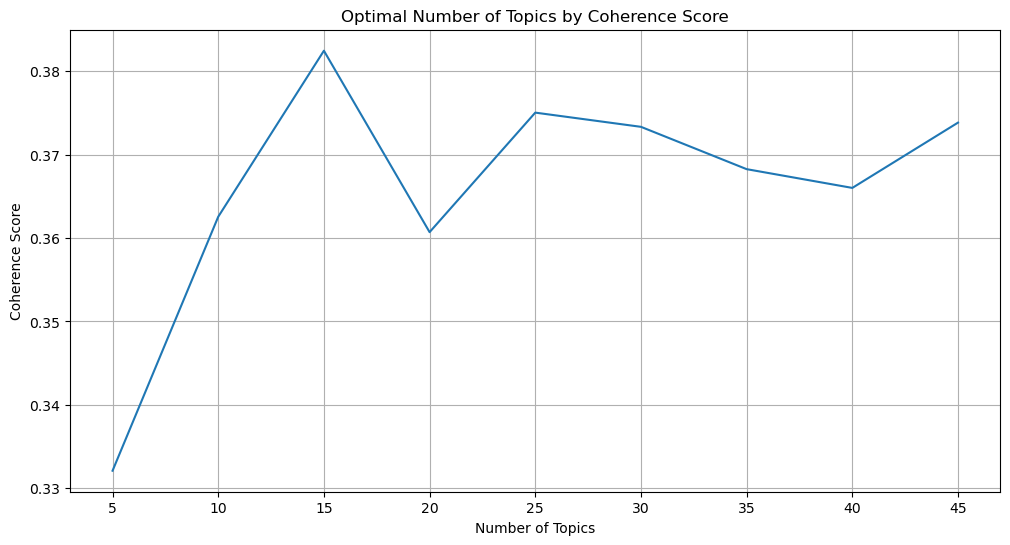

Coherence Score (c_v): 0.4084659704300906
Coherence Score (u_mass): -1.9828627821149611
Topic Diversity: 0.8466666666666667
Perplexity: -7.214725465619344


/Users/sammucyo/micromamba/envs/cs109b/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=35578) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/sammucyo/micromamba/envs/cs109b/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=35578) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/sammucyo/micromamba/envs/cs109b/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=35578) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/sammucyo/micromamba/envs/cs109b/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=35578) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/sammu

In [9]:
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Plot coherence scores for different numbers of topics
plt.figure(figsize=(12, 6))
x = range(5, 50, 5)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics by Coherence Score")
plt.grid(True)
plt.show()

# Compute other evaluation metrics
from gensim.models import CoherenceModel

# Topic coherence using c_v measure (based on word embeddings)
coherence_model_cv = CoherenceModel(model=lda_model, texts=data['tokens'], dictionary=dictionary, coherence='c_v')
coherence_cv = coherence_model_cv.get_coherence()
print(f"Coherence Score (c_v): {coherence_cv}")

# Topic coherence using u_mass (based on document co-occurrence)
coherence_model_umass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence_umass = coherence_model_umass.get_coherence()
print(f"Coherence Score (u_mass): {coherence_umass}")

# Topic diversity analysis
def calculate_topic_diversity(lda_model, num_words=10):
    """Calculate the topic diversity as the ratio of unique words in top N words across all topics"""
    topics = lda_model.show_topics(num_topics=-1, num_words=num_words, formatted=False)
    all_words = []
    for topic in topics:
        topic_words = [word for word, _ in topic[1]]
        all_words.extend(topic_words)
    unique_words = set(all_words)
    diversity = len(unique_words) / (len(topics) * num_words)
    return diversity

topic_diversity = calculate_topic_diversity(lda_model)
print(f"Topic Diversity: {topic_diversity}")

# Perplexity - a measure of how well the model predicts a sample
perplexity = lda_model.log_perplexity(corpus)
print(f"Perplexity: {perplexity}")

# Create interactive visualization
pyLDAvis.enable_notebook()
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)

### Interpreting pyLDAvis Visualization

## 1. **Intertopic Distance Map (Left Panel)**

This plot represents topic similarity visually (topics are shown as circles), where:
- the larger the circle, the more prevalent the topic in the corpus.
- Closely positioned circles indicate semantically similar topics.

#### Observations from your screenshot:

- **Topic Clustering:**
  - Most circles cluster around the center-right area, suggesting a closely related semantic cluster. 
    - (e.g., topics 1, 4, 6, 7, 8 are close, indicating overlapping content like relationships, family, life experiences.)
  - Topics like **10, 3** and **15, 14, 12** are placed away from the cluster, indicating distinct semantic themes.

- **Marginal Topic Distribution** (bottom-left corner):
  - Indicates that most topics have prevalence under 10%. There are no significantly dominant (>10%) topics, meaning the corpus covers diverse themes evenly.

---

## 2. **Top-30 Most Relevant Terms for Topic 4 (Right Panel)**

This panel shows two key metrics:

- **Overall Term Frequency (blue bars)**:
  - Indicates how common the term is across the whole corpus.

- **Estimated Term Frequency Within the Selected Topic (red bars)**:
  - Indicates how strongly each term is associated specifically with Topic 4.

**Selected topic (#4)** key terms:
- **house, home, month, leave, friend, call, talk, boyfriend**:
  - Suggests a narrative around **personal relationships, family dynamics, and possibly breakups or moving homes**.

- Terms like **say, tell, back, ask, see, could, move**:
  - Suggest conversational and reflective tone, possibly relating to personal experiences or narratives.

#### Observations from this panel:

- **High frequency vs. relevance**:
  - **House** and **home** have high frequencies overall and also high association within this topic—meaning this is a clearly defined topic about domestic/personal life.
  - Terms like **boyfriend** have lower overall frequency but are strongly relevant to Topic 4—highly characteristic of this specific topic.

---

## **Key Insights from Your pyLDAvis Visualization**:

1. **Semantic Overlap**:
   - Several topics are closely grouped, reflecting related content (personal experiences, relationships, family). Consider whether these topics can be merged or should be analyzed together.

2. **Distinct Outlier Topics**:
   - Topics like **14, 15, 12, 10, and 3** are more distinct. These should be labeled separately as they represent unique themes.

3. **Balanced Corpus**:
   - No topic overwhelmingly dominates; your corpus contains a diverse set of narratives or conversations, good for broadly exploring multiple perspectives.

4. **Clear Interpretability**:
   - Your chosen topic (#4) is easy to label ("Relationships & Personal Life") given terms like **friend, boyfriend, home, house**.

---

## **How to Use These Insights**:

- **Topic labeling**:
  Quickly interpret and assign meaningful labels based on key terms (e.g., "Family Issues," "Mental Health," "Education/School," etc.).

- **Document Tagging**:
  Identify the topic distribution of individual documents. For example, if a document strongly relates to topic #4, tag it as “Personal Life/Relationships”.

- **Analysis and Action**:
  If analyzing social media posts or user reviews, these visualizations help identify prevalent issues quickly.  
  For example:
  - If **Topic #4 (relationships)** is strongly trending upwards over time, this might signal growing attention or emerging problems related to personal life or social dynamics.

- **Recommendations**:
  You can recommend content or articles within similar topic clusters easily.

---

## **Limitations and Cautions**:

- **Interpretation Bias**:
  Remember, LDA is unsupervised. Topic meaning depends on your own interpretation. Always cross-check with human insights.

- **Topic Stability**:
  Re-run the model multiple times with different parameters to ensure consistency and stability.

---

### **Next steps you could consider**:
- Clearly label each topic.
- Inspect individual documents associated with topics to confirm interpretability.
- Integrate these topic insights into your intended use case (e.g., recommendation, trend detection).

Would you like assistance on how to specifically implement this analysis into your workflow or a practical next step?

## Assigning Topics to Posts and Analyze

In [10]:
# Get the dominant topic for each document
def get_document_topics(lda_model, corpus):
    """Get the dominant topic for each document"""
    document_topics = []
    for i, doc_topics in enumerate(lda_model[corpus]):
        # Sort topics by probability
        sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
        # Get the dominant topic
        if sorted_topics:
            dominant_topic = sorted_topics[0][0]
            topic_prob = sorted_topics[0][1]
        else:
            dominant_topic = -1
            topic_prob = 0
        document_topics.append((dominant_topic, topic_prob))
    return document_topics

# Get dominant topics
document_topics = get_document_topics(lda_model, corpus)
data['dominant_topic'] = [topic for topic, _ in document_topics]
data['topic_probability'] = [prob for _, prob in document_topics]

# Analyze posts by topic
topic_distribution = data['dominant_topic'].value_counts().sort_index()
print("Topic Distribution:")
print(topic_distribution)

# Create a summary of the top posts for each topic
def get_representative_docs(data, n_docs=3):
    """Get representative documents for each topic"""
    topic_docs = {}
    for topic_id in data['dominant_topic'].unique():
        # Filter documents for this topic and sort by probability
        topic_data = data[data['dominant_topic'] == topic_id].sort_values('topic_probability', ascending=False)
        # Get top n documents
        top_docs = topic_data['post'].head(n_docs).tolist()
        topic_docs[topic_id] = top_docs
    return topic_docs

representative_docs = get_representative_docs(data)
for topic_id, docs in representative_docs.items():
    print(f"\nTopic {topic_id} - Top Words: {lda_model.print_topic(topic_id)}")
    print("Representative Documents:")
    for i, doc in enumerate(docs):
        print(f"Document {i+1}: {doc[:200]}...")  # Print first 200 chars

Topic Distribution:
dominant_topic
0      250
1     7698
2     1677
3      115
4      151
5      693
6       55
7       14
8     1032
9      215
10      15
11     409
12     609
13     139
14     442
Name: count, dtype: int64

Topic 1 - Top Words: 0.024*"want" + 0.021*"people" + 0.019*"make" + 0.015*"thing" + 0.015*"even" + 0.014*"friend" + 0.013*"time" + 0.013*"talk" + 0.012*"try" + 0.011*"life"
Representative Documents:
Document 1: How to stop being a bad person. I hate myself so much, why cant I just stop feeling jealous and angry. But everyone is so much better than me and I cant take it I dont know I always act like im better...
Document 2: I hate social media, but I don’t want to. Can anyone relate? Pretty much just ranting here: I didn’t used to feel this way, I think it has everything to do with my lack of confidence. I used to be all...
Document 3: No one cares Even if I'm always there for my friends, when I don't feel well, nobody's here for me. I'm always listening and helpi